In [1]:
using Plots 
using LinearAlgebra 
using Parameters 
using Statistics

In [2]:
module My

using Parameters 

@with_kw struct PhysicalParam @deftype Float64
    Nsite::Int64 = 4 # number of sites in each direction
    Nthermal::Int64 = 100
    Nsweep::Int64 = 1000
    β = 1.0 # inverse temperature
end

end # module 

Main.My

In [3]:
param = My.PhysicalParam()

Main.My.PhysicalParam
  Nsite: Int64 4
  Nthermal: Int64 100
  Nsweep: Int64 1000
  β: Float64 1.0


In [4]:
function initial_gaugefields(param; random=false)
    @unpack Nsite = param
    Us = ones(ComplexF64, Nsite, Nsite, Nsite, Nsite, 4)
    if random 
        for μ in 1:4, n₄ in 1:Nsite, n₃ in 1:Nsite, n₂ in 1:Nsite, n₁ in 1:Nsite
            B = 2π*rand()
            Us[n₁, n₂, n₃, n₄, μ] = exp(im*B)
        end
    end
    return Us
end


initial_gaugefields (generic function with 1 method)

In [5]:
function update!(Us, param)
    @unpack Nsite, β = param
    
    δ(μ, ν) = ifelse(μ===ν,1,0)
    
    function f(n)
        if n < 1 
            return Nsite 
        elseif n > Nsite 
            return 1
        else
            return n
        end
    end
    
    
    for μ in 1:4, n₄ in 1:Nsite, n₃ in 1:Nsite, n₂ in 1:Nsite, n₁ in 1:Nsite
        
        U_staple = 0.0 + 0.0im
        for ν in 1:4
            if ν === μ continue end
            
            U₁ =      Us[f(n₁+δ(1,μ)), f(n₂+δ(2,μ)), f(n₃+δ(3,μ)), f(n₄+δ(4,μ)), ν]
            U₂ = conj(Us[f(n₁+δ(1,ν)), f(n₂+δ(2,ν)), f(n₃+δ(3,ν)), f(n₄+δ(4,ν)), μ])
            U₃ = conj(Us[n₁, n₂, n₃, n₄, ν])
            U_staple += U₁*U₂*U₃
            
            U₁ = conj(Us[f(n₁+δ(1,μ)-δ(1,ν)), f(n₂+δ(2,μ)-δ(2,ν)), f(n₃+δ(3,μ)-δ(3,ν)), f(n₄+δ(4,μ)-δ(4,ν)), ν])
            U₂ = conj(Us[f(n₁-δ(1,ν)), f(n₂-δ(2,ν)), f(n₃-δ(3,ν)), f(n₄-δ(4,ν)), μ])
            U₃ = Us[f(n₁-δ(1,ν)), f(n₂-δ(2,ν)), f(n₃-δ(3,ν)), f(n₄-δ(4,ν)), ν]
            U_staple += U₁*U₂*U₃
        end
        
        k = abs(U_staple)
        
        accept = false
        B = 0.0
        y = 0.0
        while(!accept)
            B = 2π*rand()
            y = exp(β*k)*rand()
            if y ≤ exp(β*k*cos(B)) 
                accept = true
                break
            end
        end
        
        
        Us[n₁, n₂, n₃, n₄, μ] = exp(im*B)*conj(U_staple)/k
    end
end

update! (generic function with 1 method)

In [6]:
param = My.PhysicalParam(Nsite=4)
Us = initial_gaugefields(param)
@time update!(Us, param)
;

  0.206791 seconds (266.33 k allocations: 15.493 MiB, 99.68% compilation time)


In [7]:
function calc_average_plaquette(param, Us)
    @unpack Nsite = param
    
    δ(μ, ν) = ifelse(μ===ν,1,0)
    
    function f(n)
        if n < 1 
            return Nsite 
        elseif n > Nsite 
            return 1
        else
            return n
        end
    end
    
    P = 0.0
    
    for ν in 1:4, μ in 1:ν-1, n₄ in 1:Nsite, n₃ in 1:Nsite, n₂ in 1:Nsite, n₁ in 1:Nsite
        U₁ = Us[n₁, n₂, n₃, n₄, μ]
        U₂ = Us[f(n₁+δ(1,μ)), f(n₂+δ(2,μ)), f(n₃+δ(3,μ)), f(n₄+δ(4,μ)), ν]
        U₃ = conj(Us[f(n₁+δ(1,ν)), f(n₂+δ(2,ν)), f(n₃+δ(3,ν)), f(n₄+δ(4,ν)), μ])
        U₄ = conj(Us[n₁, n₂, n₃, n₄, ν])
        U = U₁*U₂*U₃*U₄
        P += 1 - real(U)
    end
    
    P /= 6*Nsite^4
    return P
end

calc_average_plaquette (generic function with 1 method)

In [8]:
param = My.PhysicalParam(Nsite=4)
Us = initial_gaugefields(param; random=true)
@time P = calc_average_plaquette(param, Us)
@show P
;

  0.076619 seconds (84.40 k allocations: 5.081 MiB, 20.63% gc time, 99.93% compilation time)
P = 0.9865367486538639


In [9]:
function test_thermalization(param)
    @unpack Nsite, Nthermal, Nsweep = param
    
    # ordered start
    Us_ordered = initial_gaugefields(param)
    
    Ps_ordered = zeros(Float64, Nthermal)
    Ps_average_ordered = zeros(Float64, Nthermal)
    
    @time for isweep in 1:Nthermal
        update!(Us_ordered, param)
        Ps_ordered[isweep] = calc_average_plaquette(param, Us_ordered)
        if isweep === 1
            Ps_average_ordered[isweep] = Ps_ordered[isweep]
        else
            Ps_average_ordered[isweep] = Ps_average_ordered[isweep-1]*(isweep-1) + Ps_ordered[isweep]
            Ps_average_ordered[isweep] /= isweep
        end
    end
    
    # random start
    Us_random = initial_gaugefields(param; random=true)
    
    Ps_random = zeros(Float64, Nthermal)
    Ps_average_random = zeros(Float64, Nthermal)
    
    @time for isweep in 1:Nthermal
        update!(Us_random, param)
        Ps_random[isweep] = calc_average_plaquette(param, Us_random)
        if isweep === 1
            Ps_average_random[isweep] = Ps_random[isweep]
        else
            Ps_average_random[isweep] = Ps_average_random[isweep-1]*(isweep-1) + Ps_random[isweep]
            Ps_average_random[isweep] /= isweep
        end
    end
    
    # plot 
    p = plot(xlabel="iteration", ylabel="average plaquette")
    plot!(p, Ps_average_ordered; label="ordered start")
    plot!(p, Ps_average_random; label="random start")
    
end
    

test_thermalization (generic function with 1 method)

  2.265410 seconds
  2.249908 seconds


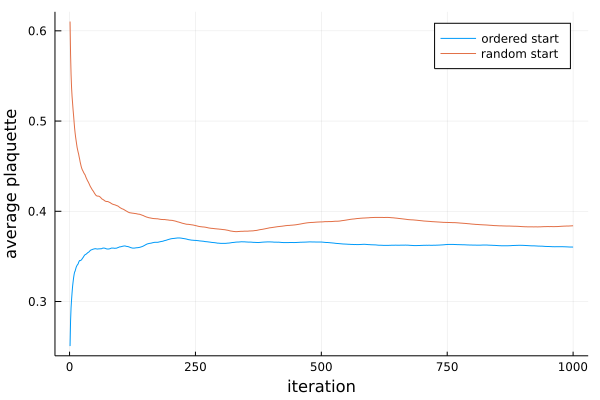

In [10]:
param = My.PhysicalParam(Nsite=6, β=1.0, Nthermal=1000)
test_thermalization(param)

  3.098449 seconds
  3.071946 seconds


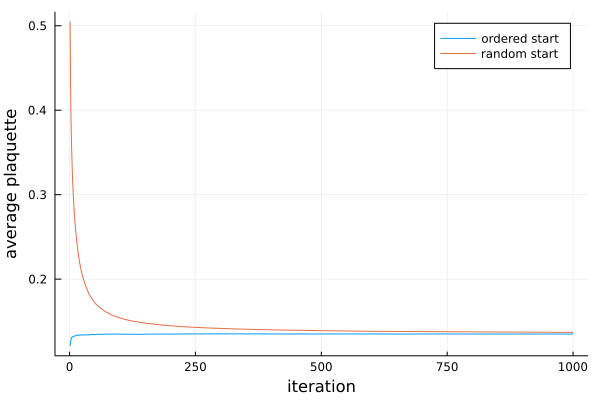

In [11]:
param = My.PhysicalParam(Nsite=6, β=2.0, Nthermal=1000)
test_thermalization(param)

  1.706475 seconds
  1.888842 seconds


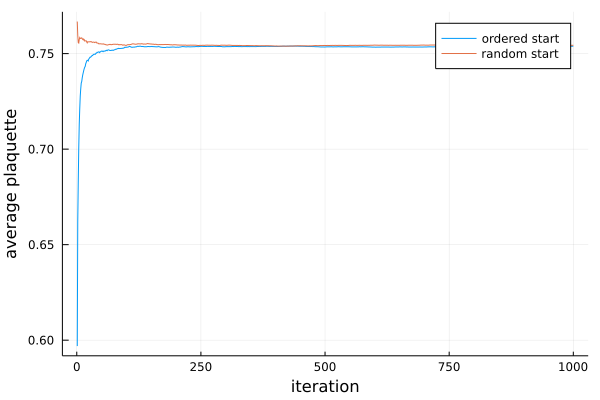

In [12]:
param = My.PhysicalParam(Nsite=6, β=0.5, Nthermal=1000)
test_thermalization(param)

In [17]:
function do_heat_bath(param; random=false)
    @unpack Nsite, Nthermal, Nsweep = param
    
    Us = initial_gaugefields(param; random=random)
    
    # thermalization
    for isweep in 1:Nthermal
        update!(Us, param)
    end
    
    # measurement
    Ps = zeros(Float64, Nsweep)
    for isweep in 1:Nthermal
        update!(Us, param)
        Ps[isweep] = calc_average_plaquette(param, Us)
    end
    
    P = mean(Ps)
    ΔP = stdm(Ps, P)
    return P, ΔP
end

do_heat_bath (generic function with 1 method)

In [76]:
param = My.PhysicalParam(Nthermal=1000, Nsweep=1000, Nsite=5)

#βs = range(0, 2, length=20+1)[2:end]
βs = 10 .^ range(-1, 1, length=50+1)

Ps_ordered = zeros(Float64, length(βs))
ΔPs_ordered = zeros(Float64, length(βs))

Ps_random = zeros(Float64, length(βs))
ΔPs_random = zeros(Float64, length(βs))

for iβ in 1:length(βs)
    param = My.PhysicalParam(param, β=βs[iβ])
    
    @time P, ΔP = do_heat_bath(param; random=false)
    Ps_ordered[iβ] = P
    ΔPs_ordered[iβ] = ΔP
    
    @time P, ΔP = do_heat_bath(param; random=true)
    Ps_random[iβ] = P
    ΔPs_random[iβ] = ΔP
end

  1.257868 seconds (9 allocations: 47.250 KiB)
  1.189311 seconds (9 allocations: 47.250 KiB)
  1.199753 seconds (9 allocations: 47.250 KiB)
  1.199142 seconds (9 allocations: 47.250 KiB)
  1.225826 seconds (9 allocations: 47.250 KiB)
  1.250715 seconds (9 allocations: 47.250 KiB)
  1.232475 seconds (9 allocations: 47.250 KiB)
  1.228915 seconds (9 allocations: 47.250 KiB)
  1.245373 seconds (9 allocations: 47.250 KiB)
  1.251609 seconds (9 allocations: 47.250 KiB)
  1.249946 seconds (9 allocations: 47.250 KiB)
  1.250087 seconds (9 allocations: 47.250 KiB)
  1.272075 seconds (9 allocations: 47.250 KiB)
  1.276914 seconds (9 allocations: 47.250 KiB)
  1.323136 seconds (9 allocations: 47.250 KiB)
  1.739515 seconds (9 allocations: 47.250 KiB)
  1.386041 seconds (9 allocations: 47.250 KiB)
  1.383382 seconds (9 allocations: 47.250 KiB)
  1.438473 seconds (9 allocations: 47.250 KiB)
  1.388889 seconds (9 allocations: 47.250 KiB)
  1.366742 seconds (9 allocations: 47.250 KiB)
  1.379812 se

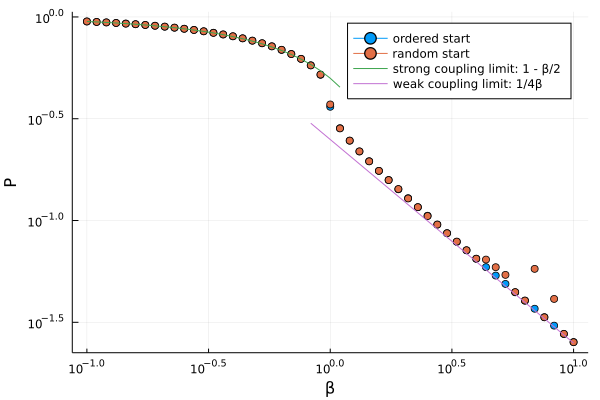

In [77]:
p = plot(xlabel="β", xaxis=:log, yaxis=:log, ylabel="P")
plot!(p, βs, Ps_ordered; marker=:dot, line=false, label="ordered start")
plot!(p, βs, Ps_random; marker=:dot, line=false, label="random start")


f(x) = ifelse(x<1.2, 1-x/2, NaN)
plot!(p, βs, f.(βs), label="strong coupling limit: 1 - β/2")

g(x) = ifelse(x>0.8, 1/4x,  NaN)
plot!(p, βs, g.(βs), label="weak coupling limit: 1/4β")

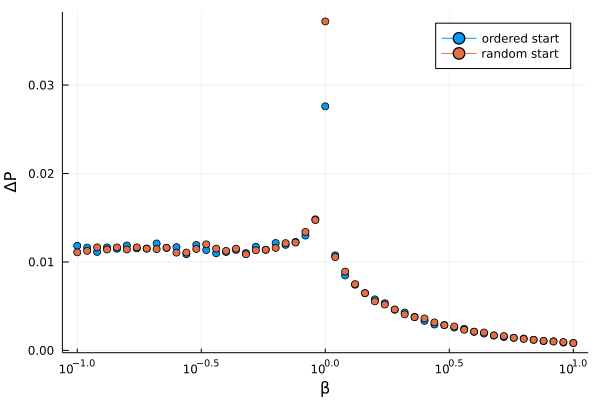

In [78]:
p = plot(xlabel="β", xaxis=:log, ylabel="ΔP")
plot!(p, βs, ΔPs_ordered; marker=:dot, line=false, label="ordered start")
plot!(p, βs, ΔPs_random; marker=:dot, line=false, label="random start")